In [1]:
import numpy as np
import cv2
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms

In [2]:
data= torchvision.datasets.OxfordIIITPet(root="/Users/dbattagodage/Desktop/Datasets/Image_Analysis",split='test',target_types='segmentation',download=True)

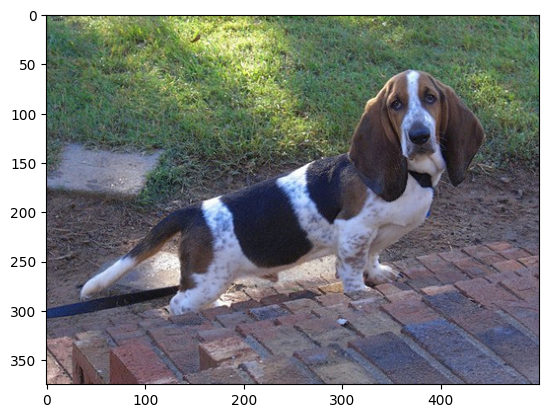

In [9]:
img = data.__getitem__(341)
#visualize the image
plt.imshow(img[0])
plt.show()

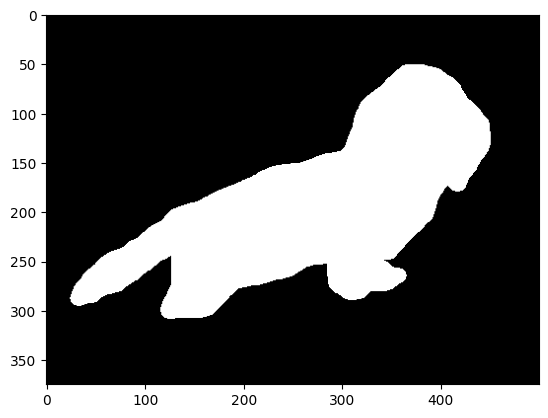

In [10]:
plt.imshow(np.array(img[1])!=2, cmap='gray'  )

In [11]:
img_np = np.array(img[0])
torch.manual_seed(0)
conv_layer= torch.nn.Conv2d(3,1,kernel_size=1,stride=1,padding=0)  # shape: [H,W,3]
img_t = torch.from_numpy(img_np).permute(2,0,1).float()/ 255.0  # shape: [3,H,W]
img_t = img_t.unsqueeze(0)  # shape: [1,3,H,W]

img_convolved = conv_layer(img_t)

In [12]:
B,C,H,W = img_convolved.shape
y = img_convolved.new_empty((B,16,C,H*W))
#arrange the pixel values in different sequences with different directions

#starting point left top corner and right bottom corner
y[:,0,:,:] = img_convolved.flatten(2,3)
y[:,1,:,:] = img_convolved.transpose(2,3).flatten(2,3)
y[:,2:4,:,:] = torch.flip(y[:,0:2,:,:],dims=[-1])

#starting point right top corner and left bottom corner
img_rotated = torch.flip(img_convolved,dims=[-1])
y[:,4,:,:] = img_rotated.flatten(2,3)
y[:,5,:,:] = img_rotated.transpose(2,3).flatten(2,3)
y[:,6:8,:,:] = torch.flip(y[:,4:6,:,:],dims=[-1])

#along the diagonals
def flatten_diagonals_rect(A):
    A = np.array(A)
    M, N = A.shape
    out = []

    for col in range(N):
        r, c = 0, col
        while r < M and c < N:
            out.append(A[r, c])
            r += 1
            c += 1

    for row in range(1, M):
        r, c = row, 0
        while r < M and c < N:
            out.append(A[r, c])
            r += 1
            c += 1

    return out

def flatten_diagonals(img_batch):
    B,C,H,W = img_batch.shape
    L=H*W
    out= torch.zeros((B,C,L),dtype=img_batch.dtype, device=img_batch.device)
    for b in range(B):
        for c in range(C):
            out[b,c,:] = torch.tensor(flatten_diagonals_rect(img_batch[b,c,:,:].detach().numpy()))
    return out
y[:,8,:,:] = flatten_diagonals(img_convolved)
y[:,9,:,:] = flatten_diagonals(img_rotated)
y[:,10:12,:,:] = torch.flip(y[:,8:10,:,:],dims=[-1])

transposed_img = img_convolved.transpose(2,3)
y[:,12,:,:] = flatten_diagonals(transposed_img)
y[:,13,:,:] = flatten_diagonals(torch.flip(transposed_img,dims=[-1]))
y[:,14:16,:,:] = torch.flip(y[:,12:14,:,:],dims=[-1])

In [13]:
y = y.detach().numpy()

In [14]:
new_y = y[0, :, 0, :].T
new_y.shape

(187500, 16)

In [15]:
correlation_matrix = np.cov(new_y,rowvar=False)
eigenvalues, eigenvectors = np.linalg.eig(correlation_matrix)
#sort the eigenvalues and eigenvectors
idx = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:,idx]

total = np.sum(eigenvalues)
recurrent_sum = 0
for r in range(len(eigenvectors)):
    recurrent_sum += eigenvalues[r]
    if recurrent_sum / total >= 0.95:
        print("Number of principal directions to cover 95% variance:", r+1)
        print("Explained variance ratio:", recurrent_sum / total)
        break
    
print("Eigenvalues:", eigenvalues)
print("Eigenvectors:", eigenvectors)

Number of principal directions to cover 95% variance: 15
Explained variance ratio: 0.9709682002750966
Eigenvalues: [0.00824189 0.0067148  0.00453641 0.00280154 0.0025435  0.00248915
 0.0020726  0.00191348 0.00147217 0.0014239  0.00142162 0.00133029
 0.00129758 0.0012658  0.00122604 0.00121844]
Eigenvectors: [[ 0.36034058  0.15981723 -0.14311804  0.12525463  0.25104828 -0.08473865
  -0.02766381 -0.36564277 -0.10523249 -0.49663738  0.13134157 -0.17630999
   0.09037337  0.50678373  0.00303956  0.1808621 ]
 [-0.08605663  0.44052384  0.08389735  0.20257541 -0.08931558 -0.06906267
   0.37558032  0.12188479  0.07321541 -0.01966848  0.25386958 -0.38277347
  -0.49253839  0.04488879  0.03431507 -0.3453908 ]
 [-0.36034058 -0.15981723 -0.14311804 -0.12525463 -0.25104828 -0.08473865
  -0.02766381 -0.36564277  0.10523249  0.49663738  0.13134157 -0.17630999
  -0.09037337  0.50678373 -0.00303956  0.1808621 ]
 [ 0.08605663 -0.44052384  0.08389735 -0.20257541  0.08931558 -0.06906267
   0.37558032  0.121

In [ ]:
np.dot(correlation_matrix,eigenvectors[:,0]) - eigenvalues[0] * eigenvectors[:,0]

In [5]:
seg_mask = np.array(img[1])!=2
H,W = seg_mask.shape
mask_coords = np.argwhere(seg_mask)

In [6]:
mask_coords

array([[102, 184],
       [102, 185],
       [102, 186],
       ...,
       [499, 372],
       [499, 373],
       [499, 374]])

In [7]:
import numpy as np

def compute_pca_axes_2d(mask_coords, max_samples=200_000):
    """
    mask_coords: (N, 2) array of (y, x) coordinates of foreground
    returns:
        centroid: (2,)
        axes: (2,2) matrix; columns = principal directions
        eigvals: (2,)
    """
    coords = mask_coords.astype(np.float64)

    # Subsample if too large
    if coords.shape[0] > max_samples:
        idx = np.random.choice(coords.shape[0], max_samples, replace=False)
        coords = coords[idx]

    # Centering
    centroid = coords.mean(axis=0)
    X = coords - centroid

    # Covariance
    cov = X.T @ X / (X.shape[0] - 1)

    # Eigen-decomposition
    eigvals, eigvecs = np.linalg.eigh(cov)   # ascending order

    # Sort descending (largest variance → first)
    order = np.argsort(eigvals)[::-1]
    eigvecs = eigvecs[:, order]
    eigvals = eigvals[order]

    # Columns are principal axes
    return {
        "centroid": centroid,
        "axes": eigvecs,   # shape (2,2)
        "eigvals": eigvals
    }

def compute_patch_centers_2d(H, W, patch_size=(32,32)):
    ph, pw = patch_size

    centers = []
    for y in range(0, H, ph):
        for x in range(0, W, pw):
            cy = y + ph/2
            cx = x + pw/2
            if cy < H and cx < W:
                centers.append([cy, cx])

    return np.array(centers)   # (num_patches, 2)

def make_sequences_from_axis_2d(patch_centers, axis_vec, centroid, bin_width, min_bins=4):
    # project (y,x) → onto 1D PCA direction
    proj = (patch_centers - centroid) @ axis_vec
    mn, mx = proj.min(), proj.max()
    nbins = max(int(np.ceil((mx - mn) / bin_width)), min_bins)
    
    bins = np.linspace(mn, mx, nbins+1)
    bin_idx = np.digitize(proj, bins) - 1   # [0 .. nbins-1]

    sequences = []
    for b in range(nbins):
        sel = np.where(bin_idx == b)[0]
        sequences.append(sel if sel.size > 0 else None)

    return sequences, bins

# --- 1. Get mask coords (y,x) ---

# mask_coords = np.argwhere(seg_mask)    # shape (N,2)

# --- 2. PCA axes in 2-D ---
pca = compute_pca_axes_2d(mask_coords)
axes = pca["axes"]        # shape (2,2), columns = PC1, PC2
cent = pca["centroid"]
# print("Centroid:",axes)
# --- 3. Compute patch centers ---
patch_centers = compute_patch_centers_2d(H, W, patch_size=(32,32))

# --- 4. Build sequences along each PCA axis ---
bin_width = 32    # usually patch size

sequences_per_axis = []
for i in range(2):     # because now we have only 2 axes
    axis_vec = axes[:, i]
    seq, bins = make_sequences_from_axis_2d(patch_centers, axis_vec, cent, bin_width)
    sequences_per_axis.append(seq)

# Now you have:
# PC1 forward     → sequences_per_axis[0]
# PC1 backward    → reversed(sequences_per_axis[0])
# PC2 forward     → sequences_per_axis[1]
# PC2 backward    → reversed(sequences_per_axis[1])
print("PC1 sequences (forward):", sequences_per_axis[0])

PC1 sequences (forward): [array([179, 188, 189, 190, 191]), array([167, 176, 177, 178, 185, 186, 187]), array([155, 164, 165, 166, 173, 174, 175, 182, 183, 184]), array([143, 152, 153, 154, 161, 162, 163, 170, 171, 172, 180, 181]), array([131, 140, 141, 142, 149, 150, 151, 158, 159, 160, 168, 169]), array([119, 128, 129, 130, 137, 138, 139, 145, 146, 147, 148, 156, 157]), array([107, 116, 117, 118, 125, 126, 127, 133, 134, 135, 136, 144]), array([ 95, 104, 105, 106, 112, 113, 114, 115, 121, 122, 123, 124, 132]), array([ 83,  92,  93,  94, 100, 101, 102, 103, 109, 110, 111, 120]), array([ 71,  80,  81,  82,  88,  89,  90,  91,  97,  98,  99, 108]), array([59, 67, 68, 69, 70, 76, 77, 78, 79, 85, 86, 87, 96]), array([47, 55, 56, 57, 58, 64, 65, 66, 73, 74, 75, 84]), array([34, 35, 43, 44, 45, 46, 52, 53, 54, 61, 62, 63, 72]), array([22, 23, 31, 32, 33, 40, 41, 42, 49, 50, 51, 60]), array([10, 11, 19, 20, 21, 28, 29, 30, 37, 38, 39, 48]), array([ 7,  8,  9, 16, 17, 18, 25, 26, 27, 36]), ar

In [ ]:
"""
## Traverse image pixels along a given 2D direction (PCA axis)  
"""
import numpy as np

def traverse_along_direction_2d(image, direction):
    """
    image: H x W
    direction: PCA direction (2D vector)
    
    Returns a deterministic sequence of pixels scanned along
    the PCA axis with a fixed traversal start.
    """

    H, W = image.shape
    A = image

    # Normalize PCA direction (this is our scanning axis)
    v = direction / np.linalg.norm(direction)

    # Create perpendicular direction
    w = np.array([-v[1], v[0]])  # rotate by 90°

    # Pixel coordinates
    ys, xs = np.meshgrid(np.arange(H), np.arange(W), indexing="ij")
    coords = np.stack([xs.ravel(), ys.ravel()], axis=1)

    # Project every pixel onto the two axes (v, w)
    proj_v = coords @ v      # main scan direction
    proj_w = coords @ w      # sweep direction

    # Digitize proj_w into “lines” (each value ≈ a diagonal slice)
    # Multiply by a resolution factor to make bins integer-like
    bins = np.floor(proj_w - proj_w.min()).astype(int)

    # Sort coordinates in a 2-tier fashion:
    #   1. increasing bins   → sweeping from one corner to the other
    #   2. increasing proj_v → along the PCA axis inside each slice
    order = np.lexsort((proj_v, bins))

    sorted_pixels = A.ravel()[order]
    sorted_coords = coords[order]
    return sorted_pixels, sorted_coords

In [ ]:
import numpy as np
A = np.arange(1, 26).reshape(5, 5)
print("Original matrix:\n", A)

In [ ]:
y,x = np.meshgrid(np.arange(5), np.arange(5), indexing='ij')
print(y,x)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_traversal_numbers(image, coords_ordered):
    H, W = image.shape
    order_map = np.full((H, W), -1, dtype=int)

    for i, (x, y) in enumerate(coords_ordered):
        order_map[y, x] = i

    plt.figure(figsize=(6,6))
    plt.imshow(order_map, cmap='viridis')
    plt.colorbar(label='Traversal order')
    plt.title("Pixel traversal order")
    plt.show()
def animate_traversal(image, coords_ordered, step=50):
    H, W = image.shape
    canvas = np.zeros((H, W))
    
    plt.figure(figsize=(6,6))

    for i in range(0, len(coords_ordered), step):
        y = coords_ordered[i][1]
        x = coords_ordered[i][0]
        canvas[y, x] = 1  # mark visited

        plt.clf()
        plt.imshow(canvas, cmap='magma')
        plt.title(f"Traversal step: {i}")
        plt.pause(0.05)

    plt.show()


def plot_direction_vector(image, direction, origin=None):
    H, W = image.shape

    if origin is None:
        origin = np.array([W//2, H//2])

    v = direction / np.linalg.norm(direction)

    plt.figure(figsize=(6,6))
    plt.imshow(image, cmap='gray')
    plt.quiver(
        origin[0], origin[1], 
        v[0], v[1], 
        color='red', scale=0.1, width=0.01
    )
    plt.title("Direction vector (PCA)")
    plt.show()

def flatten_along_axis(image, direction, center=None):
    H, W = image.shape
    v = direction / np.linalg.norm(direction)

    ys, xs = np.meshgrid(np.arange(H), np.arange(W), indexing="ij")
    coords = np.stack([xs.ravel(), ys.ravel()], axis=1)
    if center ==None:
        cx,cy = W//2, H//2
    else:
        cy, cx = center

    




    proj = coords @ v
    order = np.argsort(proj)

    sorted_coords = coords[order]
    sorted_pixels = image.ravel()[order]

    return sorted_pixels, sorted_coords

# Example 5×5 matrix
A = np.arange(1, 26).reshape(5,5)

direction = np.array([1,1])   # diagonal direction

pixels, coords = flatten_along_axis(A, direction)

# Visualize traversal numbers
visualize_traversal_numbers(A, coords)

# Visualize direction vector
plot_direction_vector(A, direction)

# Animate traversal
animate_traversal(A, coords, step=1)


print("Sorted coords:\n", coords)
print("\nSorted pixels:\n", pixels)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_pca_axes_on_image(img, mask_coords, centroid, axes, scale=200):
    """
    img: (H,W,3) numpy array
    mask_coords: (N,2) (y,x)
    centroid: (2,)
    axes: (2,2) principal directions as column vectors
    scale: how long the axis lines should be
    """
    H, W, _ = img.shape

    # PC1 and PC2
    pc1 = axes[:, 0]
    pc2 = axes[:, 1]

    cy, cx = centroid

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(img)

    # Plot mask points (optional, remove if heavy)
    ax.scatter(mask_coords[:, 1], mask_coords[:, 0], s=1, c='yellow', alpha=0.2)

    # Plot centroid
    ax.scatter([cx], [cy], color='red', s=80, label='Centroid')

    # Plot PC1 (longest direction)
    ax.plot([cx, cx + scale * pc1[1]],
            [cy, cy + scale * pc1[0]],
            color='cyan', linewidth=3, label='PC1')

    # Opposite direction
    ax.plot([cx, cx - scale * pc1[1]],
            [cy, cy - scale * pc1[0]],
            color='cyan', linewidth=3)

    # Plot PC2 (orthogonal direction)
    ax.plot([cx, cx + scale * pc2[1]],
            [cy, cy + scale * pc2[0]],
            color='magenta', linewidth=3, label='PC2')

    ax.plot([cx, cx - scale * pc2[1]],
            [cy, cy - scale * pc2[0]],
            color='magenta', linewidth=3)

    ax.set_title("PCA Axes on Image")
    ax.legend()
    plt.show()
visualize_pca_axes_on_image(img_np, mask_coords, cent, axes)


PC1 vector (manual PCA): [ 0.68798883 -0.72572128]
Mask Center (Centroid): [3.5        5.58333333]
First Principal Component Vector (PC1): [0.72572128 0.68798883]

First 5 Pixels (Left-Most) in the Arranged Order:
[[2 2]
 [2 3]
 [2 4]
 [2 5]
 [2 6]]

Last 5 Pixels (Right-Most) in the Arranged Order:
[[5 5]
 [4 7]
 [5 7]
 [6 7]
 [7 7]]


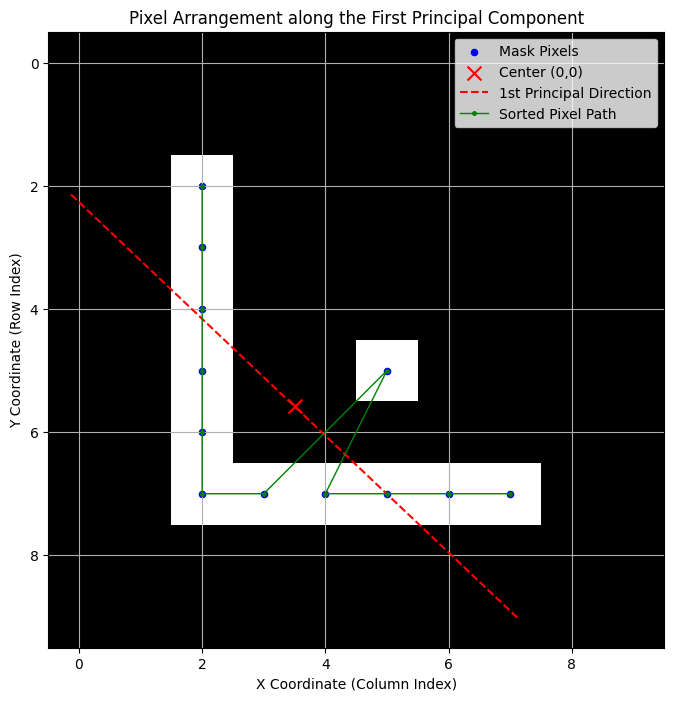

In [21]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def arrange_pixels_along_pca(mask_2d):
    """
    Arranges the coordinates of pixels within a mask along the first 
    principal component direction.

    Args:
        mask_2d (np.ndarray): A 2D numpy array where True/1 indicates 
                              a pixel to include (the mask).

    Returns:
        tuple: (sorted_coords, center, pc1_vector)
               - sorted_coords (np.ndarray): Coordinates sorted along the 1st PC.
               - center (np.ndarray): The mean coordinate (center of mass).
               - pc1_vector (np.ndarray): The 1st principal component vector.
    """
    # 1. Extract Coordinates
    # Get the (row, col) coordinates of all masked pixels
    rows, cols = np.where(mask_2d)
    coords = np.vstack([cols, rows]).T  # Shape (N, 2), using (x, y) = (col, row)

    if coords.shape[0] == 0:
        print("Mask is empty.")
        return np.array([]), np.array([0, 0]), np.array([0, 0])

    # 2. Center the Data
    # Center is the mean of the coordinates (centroid of the mask)
    center = np.mean(coords, axis=0)
    centered_coords = coords - center

    # Perform manual PCA
    covariance_matrix = np.cov(centered_coords, rowvar=False)
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
    # Sort eigenvectors by eigenvalues in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvectors = eigenvectors[:, sorted_indices]
    pc1_vector_manual = eigenvectors[:, 1]  
    print("PC1 vector (manual PCA):", pc1_vector_manual)

    # 3. Perform PCA
    # We only need the first component (PC1)
    pca = PCA(n_components=1)
    pca.fit(centered_coords)

    # The principal direction (PC1) vector
    pc1_vector = pca.components_[0] 
    # Ensure the vector points roughly "right" for visualization consistency
    if pc1_vector[0] < 0:
        pc1_vector = -pc1_vector

    # 4. Transformation (Projection)
    # The projection is the dot product of the centered coordinates and the 
    # principal direction vector. This gives the 1D coordinate along the PC axis.
    projection_onto_pc1 = np.dot(centered_coords, pc1_vector) 
    # projection_onto_pc1 is a 1D array of shape (N,)

    # 5. Sorting
    # Get the indices that would sort the projected values
    sort_indices = np.argsort(projection_onto_pc1)

    # Use these indices to sort the original coordinates
    sorted_coords = coords[sort_indices]

    return sorted_coords, center, pc1_vector

# --- Example Usage ---

# Create a sample L-shaped mask (a common shape in image analysis)
mask_shape = (10, 10)
sample_mask = np.zeros(mask_shape, dtype=bool)

# Define the L shape
sample_mask[2:8, 2] = True  # Vertical part
sample_mask[7, 2:8] = True  # Horizontal part
sample_mask[5, 5] = True # Add a pixel in the middle for a better center

# Get the sorted pixels and the PC info
sorted_pixels, center, pc1 = arrange_pixels_along_pca(sample_mask)

print(f"Mask Center (Centroid): {center}")
print(f"First Principal Component Vector (PC1): {pc1}")
print("\nFirst 5 Pixels (Left-Most) in the Arranged Order:")
print(sorted_pixels[:5])
print("\nLast 5 Pixels (Right-Most) in the Arranged Order:")
print(sorted_pixels[-5:])

# --- Visualization (Highly Recommended to understand the process) ---

plt.figure(figsize=(8, 8))
plt.imshow(sample_mask, cmap='gray', origin='upper')
rows, cols = np.where(sample_mask)
plt.scatter(cols, rows, c='blue', s=20, label='Mask Pixels') # Plot all pixels

# 1. Plot the center (origin of the new coordinate system)
plt.scatter(center[0], center[1], c='red', marker='x', s=100, label='Center (0,0)')

# 2. Plot the Principal Direction (PC1)
# Draw a line along the PC1 vector passing through the center
scale = 5 # Extend the line for visualization
plt.plot(
    [center[0] - pc1[0] * scale, center[0] + pc1[0] * scale],
    [center[1] - pc1[1] * scale, center[1] + pc1[1] * scale],
    c='red', linestyle='--', label='1st Principal Direction'
)

# 3. Highlight the sorted path
# Connect the sorted points to visualize the traversal order
plt.plot(sorted_pixels[:, 0], sorted_pixels[:, 1], c='green', linewidth=1, marker='.', markersize=5, label='Sorted Pixel Path')
plt.title("Pixel Arrangement along the First Principal Component")
plt.xlabel("X Coordinate (Column Index)")
plt.ylabel("Y Coordinate (Row Index)")
plt.legend()
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()